In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [6]:
# Some basic operators
sigma = np.array([np.eye(2, dtype=complex) for _ in range(4)])
sigma[1] = np.array([[0,1],[1,0]])
sigma[2] = np.array([[0,-1j],[1j,0]])
sigma[3] = np.array([[1,0],[0,-1]])

def rx_gate(theta):
    return scipy.linalg.expm(-1j * sigma[1] * theta / 2)

def ry_gate(theta):
    return scipy.linalg.expm(-1j * sigma[2] * theta / 2)

def rz_gate(theta):
    return scipy.linalg.expm(-1j * sigma[3] * theta / 2)

cz_gate = np.eye(4); cz_gate[3,3] = -1

print(f'CZ gate:\n{cz_gate}')

CZ gate:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


In [7]:
def random_circuit(qubits_num, layers_num):
    """Generates random 'qubits_num'-qubit circuit with 
    'layers_num' layers of gates.
    Each layer inclueds random single-qubit and fixed two-qubit gates
    """
    resulting_unitary = np.eye(2 ** qubits_num, dtype=complex)

    for layer_ind in range(layers_num):
        # Adding two-qubit gates:
        if layer_ind % 2: # even layer
            layer_content = np.eye(2, dtype=complex)
            for _ in range((qubits_num-1) // 2):
                layer_content = np.kron(layer_content, cz_gate)
        
        else: # odd layer
            layer_content = np.eye(1, dtype=complex)
            for _ in range(qubits_num // 2):
                layer_content = np.kron(layer_content, cz_gate)

        # Additional identity if needed:
        if layer_content.shape[0] < 2 ** qubits_num: 
            layer_content = np.kron(layer_content, sigma[0])
        
        # Adding single-qubit gates:
        random_1qb_rotations = np.eye(1, dtype=complex)
        for _ in range(qubits_num):
            theta1, theta2, theta3 = 2 * np.pi * np.random.rand(3)
            random_1qb_rotation = (rz_gate(theta3) @ 
                                   rx_gate(theta2) @ 
                                   rz_gate(theta1))
            random_1qb_rotations = np.kron(random_1qb_rotations, 
                                           random_1qb_rotation)
        
        layer_content = random_1qb_rotations @ layer_content
        resulting_unitary = layer_content @ resulting_unitary
        
    return resulting_unitary

def generate_truely_random_distr(qubits_num):
    """Genrates uniformly random state (according to the Haar measure)
    and calculates corresponding probability distribution
    """
    vec = np.random.normal(0, 1, 2 ** qubits_num) + \
          1j * np.random.normal(0, 1, 2 ** qubits_num)
    probs = np.array([np.abs(vec[i]) ** 2 
                      for i in range(2 ** qubits_num)])
    probs = probs / np.sum(probs)
    return probs

Check of probabilities sum: 1.0


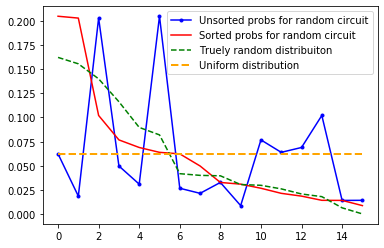

In [8]:
# Let's compare true random distribution and the one 
# from a random-like circuit
qubits_num = 4
layers_num = 20

initial_vec = np.zeros((2 ** qubits_num, 1)); initial_vec[0] = 1
circuit = random_circuit(qubits_num, layers_num)
final_vec = circuit @ initial_vec

final_probs = [np.abs(final_vec[i][0]) ** 2 
               for i in range(2 ** qubits_num)]

true_random_probs = np.sort(generate_truely_random_distr(qubits_num))

print(f'Check of probabilities sum: {np.sum(final_probs).round(10)}')

_, ax = plt.subplots()
ax.plot(final_probs, '.-', color = 'blue')
ax.plot(np.sort(final_probs)[::-1], '-', color = 'red')
ax.plot(true_random_probs[::-1], '--', color = 'green')
ax.plot([0,2 ** qubits_num - 1], [1/(2 ** qubits_num),1/(2 ** qubits_num)], 
        '--', lw = 2, color = 'orange')
ax.legend(['Unsorted probs for random circuit', 
           'Sorted probs for random circuit', 
           'Truely random distribuiton', 
           'Uniform distribution'])

In [11]:
def add_noise(probs, fidelity):
    """
    Adding white noise to input probability
    fidelity = 0 -- noise only
    fidelity = 1 -- no noise
    """
    return fidelity * np.array(probs) + (1 - fidelity) * \
        np.ones(2 ** qubits_num) / (2 ** qubits_num)

Text(0.5, 1.0, 'Fidelity = 0.4')

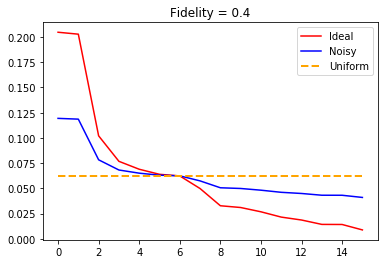

In [12]:
# Let's see how the noise affects our probability distribution
fidelity = 0.4
final_probs_with_noise = add_noise(final_probs, fidelity)

_, ax = plt.subplots()
ax.plot(np.sort(final_probs)[::-1], '-', color = 'red')
ax.plot(np.sort(final_probs_with_noise)[::-1], '-', color = 'blue')
ax.plot([0,2 ** qubits_num - 1], 
        [1/(2 ** qubits_num),1/(2 ** qubits_num)], 
        '--', lw = 2, color = 'orange')
ax.legend(['Ideal', 'Noisy', 'Uniform'])
ax.set_title(f'Fidelity = {fidelity}')

In [13]:
def sample_from_circuit(probs, runs_num, qubits_num):
    """Samples bitstring treated as integers from 
    given distribution
    """
    return [np.random.choice(range(2 ** qubits_num), p=probs) 
            for _ in range(runs_num)]

def calculate_XEB(samples_list, probs, qubits_num):
    """Calculates linear cross-entropy benchmark
    """
    probs_array = [probs[sample] for sample in samples_list]
    return 2 ** qubits_num * np.mean(probs_array) - 1

In [22]:
# Let's see how XEB behaves
runs_num = 10
fidelity = 0.1

final_probs_with_noise = add_noise(final_probs, fidelity)

circuit_results = sample_from_circuit(final_probs, 
                                      runs_num, 
                                      qubits_num)
rand_results = np.random.randint(2 ** qubits_num, size=runs_num)
noisy_circuit_results = sample_from_circuit(final_probs_with_noise, 
                                            runs_num, 
                                            qubits_num)

print(f'Ideal circuit samples:\n{np.array(circuit_results)}',
      f'\nRandom samples:\n{np.array(rand_results)}',
      f'\nNoisy circuit samples:\n{np.array(noisy_circuit_results)}\n')

XEB_circuit = calculate_XEB(circuit_results, final_probs, qubits_num)
XEB_random = calculate_XEB(rand_results, final_probs, qubits_num)
XEB_noisy_circuit = calculate_XEB(noisy_circuit_results, 
                                  final_probs,
                                  qubits_num)

print( 'Values of XEB:\n'
      f'ideal circuit:\t{XEB_circuit.round(4)}\n'
      f'random gen:\t{XEB_random.round(4)}\n'
      f'noisy circuit:\t{XEB_noisy_circuit.round(4)}')

Ideal circuit samples:
[11 13 13  1  1 15  9 13  8  2] 
Random samples:
[ 5 12 11  9  6 14  5  7  3  7] 
Noisy circuit samples:
[ 5  0 10 10 15  0  8  6  2  3]

Values of XEB:
ideal circuit:	0.4731
random gen:	-0.2707
noisy circuit:	-0.3778
